In [12]:
import os
os.chdir(r"Code\DataPrep\utils")
from settings import *

os.chdir(r"C:\Users\cflorelu\Documents\1_Ternium\Resumenes-Python\04_Machine Learning Scientist\12_Natural_Lenguague\Model\Code\DataPrep")
import importData as importData
import preprocessing as preprocessing
import exploratoryData as exploratoryData
import dataModeling as dataModeling
#from trainModel import *
#from reporting import *

os.chdir(r"C:\Users\cflorelu\Documents\1_Ternium\Resumenes-Python\04_Machine Learning Scientist\12_Natural_Lenguague\Model")
datos = importData.read_data(ruta_feedback)

#-- preprocessing --#
experimento = 'Eventos con evaluación == 0'

datos = preprocessing.reordering_data(datos_a_corregir= datos,
                                      evaluaciones_sin_ceros = False) #Si es True (descarta los ceros)

datos = preprocessing.vectorizing_data(datos_a_procesar = datos,
                                       model_w2v = model_w2v,
                                       pdt = ProcesadorDeTexto()).reset_index()

#-- dataModeling --#
x_entrna, y_entrna, x_valida, y_valida, x_prueba, y_prueba = dataModeling.split_data(datos_a_dividir = datos, 
                                                                                     p_explr_prueba = .7,
                                                                                     p_entrn_valida = .7,
                                                                                     )

noms_cols_caracts = ['TEXTO_COMPARACION_VECT',
                     'D_EVENTO_VECT',
                     'DIFF_TEXTO_COMPARACION_VECT_&_D_EVENTO_VECT']

feats_entrna, labels_entrna, qids_entrna = dataModeling.obtener_CEQs(X = x_entrna, # Listas con las características, etiquetas y grupos utilizadas en el entrenamiento del modelo
                                                                     y = y_entrna,
                                                                     noms_cols_caracts = noms_cols_caracts)

feats_valida, labels_valida, qids_valida = dataModeling.obtener_CEQs(X = x_valida,
                                                                     y = y_valida,
                                                                     noms_cols_caracts = noms_cols_caracts)

feats_prueba, labels_prueba, qids_prueba = dataModeling.obtener_CEQs(X = x_prueba,
                                                                     y = y_prueba,
                                                                     noms_cols_caracts = noms_cols_caracts)

###########################
# -- BestModel metrics -- #
###########################
params = {'objective': 'rank:ndcg',
          'reg_lambda' : .1,
          'subsample': 0.3,
          'gamma': .001,
          'missing': -99,
          'eval_metric': ['map','ndcg','ndcg@5','ndcg@10','rmse','auc']}

model_l2r = xgboost.XGBRanker(**params)

model_l2r.fit(X = feats_entrna,
              y = labels_entrna,
              qid = qids_entrna,
              eval_set = [(feats_entrna, labels_entrna), 
                          (feats_valida, labels_valida)],
              eval_qid = [qids_entrna,
                          qids_valida],
              verbose = False)

###############
#-- Reporte --#
###############
x_entrna["RANK"] = labels_entrna
x_entrna["y_pred"] = model_l2r.predict(feats_entrna)
x_entrna["rank_l2r"] = (x_entrna.groupby('QID')['y_pred']
                                .rank(method='dense', ascending = False)
                                .astype(int))
x_entrna["datos"] = 'entrenamiento'

#Valida
x_valida["RANK"] = labels_valida
x_valida["y_pred"] = model_l2r.predict(feats_valida)
x_valida["rank_l2r"] = (x_valida.groupby('QID')['y_pred']
                                .rank(method='dense', ascending = False)
                                .astype(int))
x_valida["datos"] = 'valida'

#Prueba
x_prueba["RANK"] = labels_prueba
x_prueba["y_pred"] = model_l2r.predict(feats_prueba)
x_prueba["rank_l2r"] = (x_prueba.groupby('QID')['y_pred']
                                .rank(method='dense', ascending = False)
                                .astype(int))
x_prueba["datos"] = 'prueba'

#Union
datos_l2r = pd.concat([x_entrna, x_valida, x_prueba])

#Rank similitud
import numpy as np
from sklearn.metrics import ndcg_score

datos_l2r['rank_w2v'] = datos_l2r.groupby("QID")["SIMILITUD"].rank('first', ascending =  False)
datos_l2r['rank_w2v'] = datos_l2r['rank_w2v'].astype(int)
datos_l2r['RANK'] = datos_l2r['RANK'].astype(int)

#ndcg por grupo QID
qid = list(set(datos_l2r["QID"]))

ndcg_l2r = []
ndcg_w2v = []

qids = []
dato = []

for i in range(len(qid)):
    
    dat = datos_l2r[datos_l2r["QID"] == qid[i]]['datos'].unique()[0]
    rank_origin = np.asarray([list(datos_l2r[datos_l2r["QID"] == qid[i]].loc[:,['RANK']]['RANK'])])
    rank_l2r = np.asarray([list(datos_l2r[datos_l2r["QID"] == qid[i]].loc[:,['rank_l2r']]['rank_l2r'])])
    rank_w2v = np.asarray([list(datos_l2r[datos_l2r["QID"] == qid[i]].loc[:,['rank_w2v']]['rank_w2v'])])
    
    dato.append(dat)
    qids.append(qid[i])
    
    if rank_origin.shape[1] == 1:
        
        ndcg_l2r.append(1)
        ndcg_w2v.append(1)

    else:
        
        ndcg_l2r.append(ndcg_score(rank_l2r, rank_origin))
        ndcg_w2v.append(ndcg_score(rank_w2v, rank_origin))

df_ndcg = pd.DataFrame(zip(qids, ndcg_l2r, ndcg_w2v, dato),
                       columns = ['qids','ndcg_l2r', 'ndcg_w2v','dato'])

df_ndcg['dif_ndcg'] = df_ndcg['ndcg_l2r'] - df_ndcg['ndcg_w2v']

df_ndcg.groupby(["dato"]).agg({'ndcg_l2r':'mean'})
df_ndcg.groupby(["dato"]).agg({'ndcg_w2v':'mean'})

#Histograma
df = df_ndcg.loc[:,["dato","ndcg_l2r", "ndcg_w2v"]]

df = df.melt(id_vars=['dato'], 
             value_vars=["ndcg_l2r", "ndcg_w2v"])


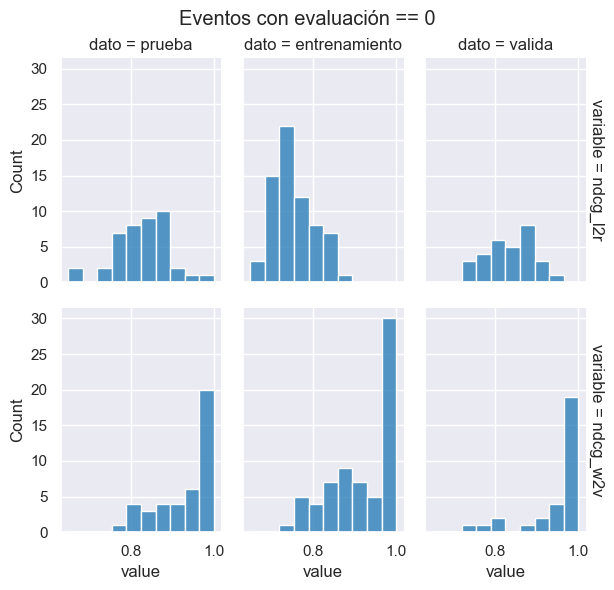

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid", palette=None)

rel = sns.displot(df,
                  x = "value",
                  col="dato",
                  row="variable",
                  facet_kws=dict(margin_titles=True),
                  height=3,
                  aspect=.7)

rel.fig.subplots_adjust(top = .9)
rel.fig.suptitle('{}'.format(experimento))
plt.show()

In [13]:
#############################################
#¿Como está rankeando los valores + , - y 0?#
#############################################

df_ndcg

round(datos_l2r["EVALUACION_SUM"].value_counts(normalize = True),2)

datos_l2r.columns
datos_l2r = datos_l2r.drop(['TEXTO_COMPARACION_VECT', 'D_EVENTO_VECT',
                            'DIFF_TEXTO_COMPARACION_VECT_&_D_EVENTO_VECT'], axis = 1)

datos_l2r.loc[datos_l2r["EVALUACION_SUM"] == 0, 'eventos_sin_feedback'] = 1
datos_l2r["n_eventos"] = 1



In [14]:
tmp = datos_l2r.groupby(["QID","datos"], as_index = False).agg({"n_eventos":"count",
                                                                "eventos_sin_feedback":"sum"})

tmp["evento_feedback"] = tmp["n_eventos"] - tmp["eventos_sin_feedback"]
tmp = tmp.loc[:,["QID", "n_eventos","eventos_sin_feedback","evento_feedback"]]
tmp = pd.concat([df_ndcg, tmp], axis = 1).loc[:,["QID","ndcg_l2r","ndcg_w2v","eventos_sin_feedback","evento_feedback","n_eventos"]]

tmp = tmp.sort_values("n_eventos").reset_index().reset_index()

tmp.to_csv("tmp.csv")

In [15]:
tmp

,level_0,index,QID,ndcg_l2r,ndcg_w2v,eventos_sin_feedback,evento_feedback,n_eventos
0,0,138,139,1.000000,1.000000,1.0,0.0,1
1,1,139,140,0.859719,1.000000,2.0,0.0,2
2,2,120,121,0.766781,1.000000,4.0,0.0,4
3,3,64,65,0.881331,0.862399,2.0,2.0,4
4,4,136,137,0.768654,0.935988,5.0,1.0,6
...,...,...,...,...,...,...,...,...
135,135,18,19,0.857249,0.846559,79.0,6.0,85
136,136,75,76,0.800097,0.999997,87.0,3.0,90
137,137,25,26,0.814953,0.997153,100.0,9.0,109
138,138,100,101,0.893742,0.849841,109.0,8.0,117


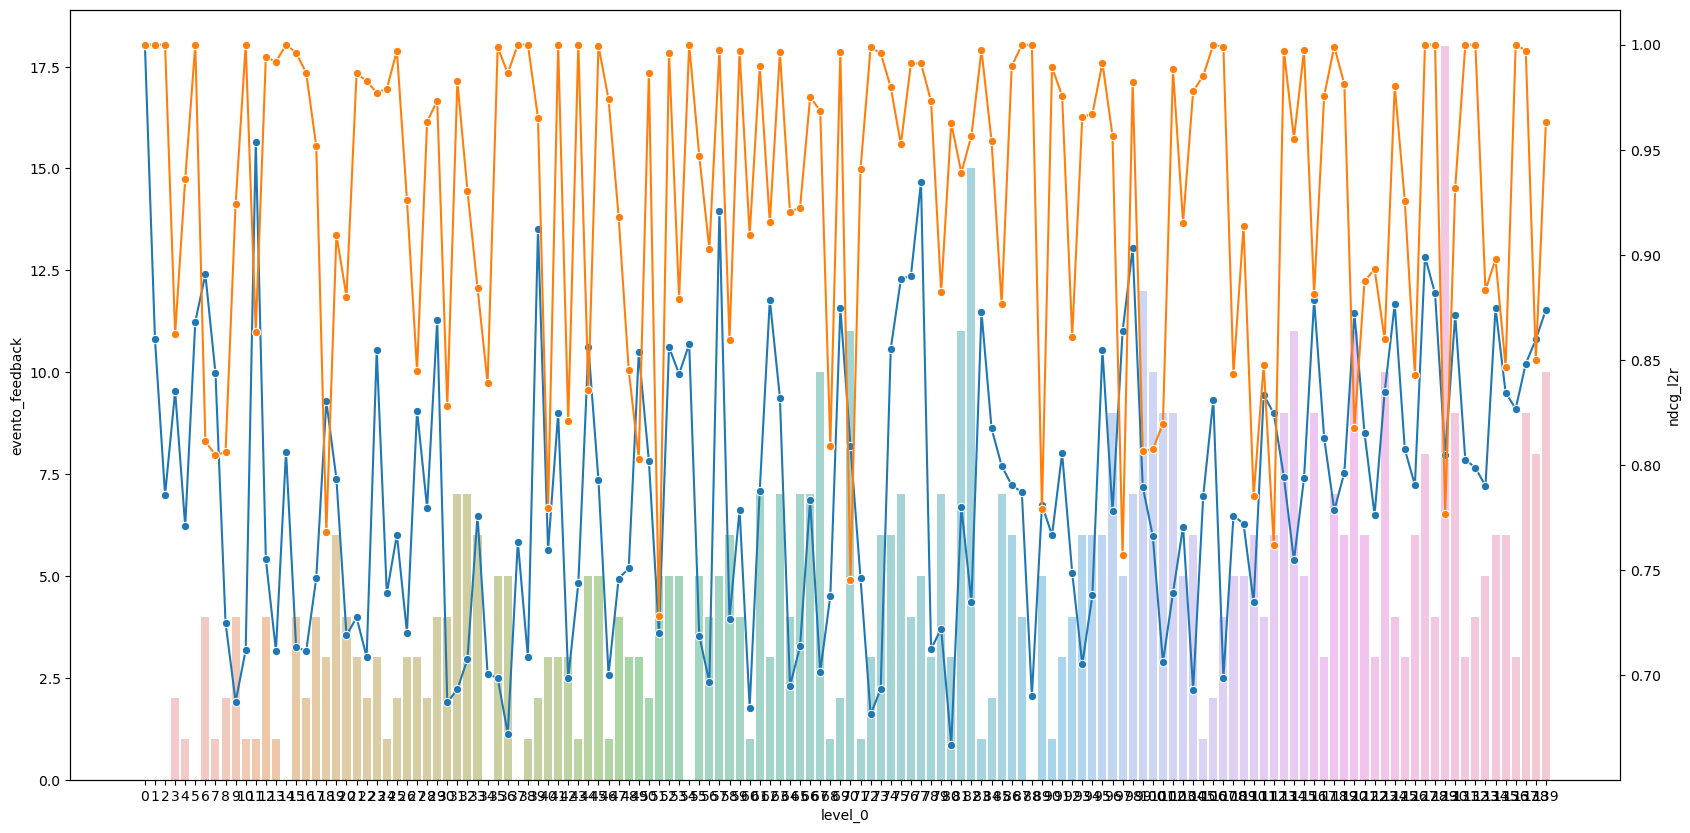

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(20,10))

#plot_order = conteo["level_0"].unique()

sns.barplot(data = tmp,
            x = 'level_0',
            y = 'evento_feedback',
            #hue = 'variable',
            alpha = 0.5,
            ax = ax1,)

ax2 = ax1.twinx()

sns.lineplot(data = tmp,
             x = 'level_0',
             y = 'ndcg_l2r',
             marker='o',
             ax = ax2,
             )

sns.lineplot(data = tmp,
             x = 'level_0',
             y = 'ndcg_w2v',
             marker='o',
             ax = ax2,
             )

plt.show()


In [20]:
tmp.loc[:,["ndcg_l2r",	"ndcg_w2v",	"eventos_sin_feedback",	"evento_feedback",	"n_eventos"]].corr()

,ndcg_l2r,ndcg_w2v,eventos_sin_feedback,evento_feedback,n_eventos
ndcg_l2r,1.000000,0.097485,0.210255,-0.070651,0.191162
ndcg_w2v,0.097485,1.000000,-0.001399,-0.245832,-0.032489
eventos_sin_feedback,0.210255,-0.001399,1.000000,0.323480,0.992782
evento_feedback,-0.070651,-0.245832,0.323480,1.000000,0.434626
n_eventos,0.191162,-0.032489,0.992782,0.434626,1.000000
